# Ensamble de Árboles de Decisión (Random Forest) para Diagnóstico de Cáncer de Mama

**Objetivo:**
El objetivo de este notebook es construir, entrenar y evaluar un modelo de ensamble de árboles de decisión (Random Forest) para predecir si un tumor de mama es maligno o benigno, utilizando el dataset "Breast Cancer Wisconsin". Se explorarán las características del dataset, se entrenará el clasificador, se evaluará su rendimiento utilizando diversas métricas, se visualizará la importancia de las características y se analizará un ejemplo específico. También se mostrará cómo visualizar uno de los árboles individuales dentro del ensamble.

## 1. Carga de Librerías y Configuración Inicial

**Propósito de esta sección:**
Importar todas las bibliotecas necesarias y configurar el entorno para el análisis.

**Bibliotecas Clave:**
* **`numpy`**: Para operaciones numéricas.
* **`pandas`**: Para manipulación y análisis de datos (DataFrames).
* **`matplotlib.pyplot`**: Para la creación de gráficos estáticos.
* **`seaborn`**: Para visualizaciones estadísticas más atractivas.
* **`sklearn.datasets`**: Para cargar datasets de ejemplo como "Breast Cancer".
* **`sklearn.model_selection`**: Para dividir datos en conjuntos de entrenamiento y prueba.
* **`sklearn.ensemble`**: Contiene los clasificadores de ensamble como `RandomForestClassifier`.
* **`sklearn.tree`**: Para visualizar árboles individuales (`plot_tree`).
* **`sklearn.metrics`**: Para métricas de evaluación como `accuracy_score`, `classification_report`, `confusion_matrix`.

**Configuraciones Adicionales:**
Se establecen configuraciones para la visualización de gráficos y recarga automática de módulos (opcional en scripts, útil en notebooks).

In [1]:
# Comandos mágicos de IPython para recarga automática de módulos (opcional).
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Mostrar gráficos de Matplotlib inline en el notebook.
%matplotlib inline

In [2]:
# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree # Para visualizar un árbol individual del ensamble
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Establecer estilo de seaborn para los gráficos.
sns.set(style="whitegrid")

In [3]:
# Configuración global de los gráficos de matplotlib.
plt.rcParams['figure.figsize'] = [12, 7]  # Tamaño de figura por defecto (ancho, alto) en pulgadas.
plt.rcParams['figure.dpi'] = 100  # Resolución en puntos por pulgada (DPI).
plt.rcParams['font.size'] = 10 # Tamaño de fuente por defecto.

## 2. Funciones Personalizadas

Esta sección define funciones auxiliares para modularizar el código y facilitar tareas como la carga de datos, entrenamiento del modelo de ensamble, visualización de la importancia de características y análisis de ejemplos.

### Descripción de la Función: `cargar_datos_cancer`

**Objetivo Principal:**
Cargar el dataset "Breast Cancer Wisconsin" desde `sklearn.datasets`, transformarlo en un DataFrame de Pandas y añadir nombres descriptivos para las clases objetivo.

**Características:**
* **Procesamiento:**
    1. Carga el dataset "Breast Cancer".
    2. Crea un DataFrame con las características y sus nombres.
    3. Añade la columna 'target' (clases numéricas).
    4. Mapea las clases numéricas a nombres descriptivos (ej: 'malignant', 'benign').
    5. Imprime información descriptiva: dimensiones, primeras filas, estadísticas y distribución de la variable objetivo.
* **Valor de Retorno:**
    * `df` (pd.DataFrame): El DataFrame procesado.
    * `feature_names` (list): Lista de nombres de las características.
    * `target_names_list` (list): Lista de nombres de las clases objetivo.

In [4]:
def cargar_datos_cancer():
    """
    Carga el dataset de Cáncer de Mama, lo prepara y muestra información descriptiva.

    Returns:
        df (pd.DataFrame): DataFrame con los datos.
        feature_names (np.ndarray): Array con los nombres de las características.
        target_names_list (list): Lista con los nombres de las clases.
    """
    print("Cargando el dataset de Cáncer de Mama Wisconsin...")
    cancer_data = load_breast_cancer()
    df = pd.DataFrame(data=cancer_data.data, columns=cancer_data.feature_names)
    df['target'] = cancer_data.target
    
    # Crear una columna con nombres de clase descriptivos
    # En este dataset: 0 es 'malignant', 1 es 'benign'
    target_names_list = list(cancer_data.target_names)
    df['diagnosis'] = df['target'].map({i: name for i, name in enumerate(target_names_list)})


    print("\nDimensiones del dataset:", df.shape)
    print("\nPrimeras filas del dataset:")
    print(df.head())
    print("\nEstadísticas descriptivas de las características:")
    # Mostrar estadísticas solo de las columnas numéricas (excluyendo 'target' y 'diagnosis' temporalmente)
    print(df.drop(columns=['target', 'diagnosis']).describe().T) # Transponer para mejor legibilidad
    
    print("\nInformación del DataFrame (tipos de datos, nulos):")
    df.info()

    print("\nDistribución de la variable objetivo ('diagnosis'):")
    print(df['diagnosis'].value_counts(normalize=True))

    return df, cancer_data.feature_names, target_names_list

### Descripción de la Función: `crear_entrenar_ensemble_rf`

**Objetivo Principal:**
Crear y entrenar un modelo Random Forest para clasificar los tumores y evaluar su rendimiento en un conjunto de prueba.

**Características:**
* **Entrada:**
    * `df` (pd.DataFrame): DataFrame con las características y la columna 'target'.
    * `feature_names` (list): Lista de nombres de las columnas de características.
    * `target_column` (str): Nombre de la columna objetivo (por defecto 'target').
    * `n_estimators` (int): Número de árboles en el bosque (por defecto 100).
    * `test_proportion` (float): Proporción del dataset a usar como conjunto de prueba.
    * `seed` (int): Semilla aleatoria para reproducibilidad.
* **Procesamiento:**
    1. Separa las características (X) y la variable objetivo (y).
    2. Divide los datos en conjuntos de entrenamiento y prueba (`train_test_split`) con estratificación.
    3. Crea una instancia de `RandomForestClassifier`.
    4. Entrena el clasificador (`clf.fit`).
    5. Realiza predicciones en el conjunto de prueba.
    6. Calcula y muestra la precisión, el reporte de clasificación y la matriz de confusión.
* **Valor de Retorno:**
    * `clf` (RandomForestClassifier): El clasificador Random Forest entrenado.
    * `X_train`, `X_test`, `y_train`, `y_test`: Conjuntos de datos divididos.

In [5]:
def crear_entrenar_ensemble_rf(df, feature_names, target_column='target', n_estimators_val=100, test_proportion=0.3, seed=42):
    """
    Crea, entrena un Random Forest y evalúa su rendimiento.

    Args:
        df (pd.DataFrame): DataFrame con características y la columna objetivo.
        feature_names (list): Lista de nombres de las características.
        target_column (str): Nombre de la columna objetivo.
        n_estimators_val (int): Número de árboles en el bosque.
        test_proportion (float): Proporción para el conjunto de prueba.
        seed (int): Semilla aleatoria.

    Returns:
        clf (RandomForestClassifier): Clasificador entrenado.
        X_train, X_test, y_train, y_test: Conjuntos de datos divididos.
    """
    print(f"\nCreando y entrenando el Random Forest (n_estimators={n_estimators_val})...")

    X = df[feature_names]
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_proportion, random_state=seed, stratify=y
    )
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras.")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras.")

    clf = RandomForestClassifier(n_estimators=n_estimators_val, random_state=seed, oob_score=True)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nPrecisión del Random Forest en el conjunto de prueba: {accuracy:.4f}")
    if hasattr(clf, 'oob_score_'):
        print(f"Out-of-Bag (OOB) Score: {clf.oob_score_:.4f}")


    print("\nReporte de Clasificación:")
    # target_names se refiere a los nombres de las clases para el reporte
    class_report = classification_report(y_test, y_pred, target_names=load_breast_cancer().target_names)
    print(class_report)

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=load_breast_cancer().target_names, yticklabels=load_breast_cancer().target_names)
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    return clf, X_train, X_test, y_train, y_test

### Descripción de la Función: `visualizar_importancia_caracteristicas`

**Objetivo Principal:**
Visualizar la importancia de cada característica según el modelo Random Forest entrenado.

**Características:**
* **Entrada:**
    * `clf` (RandomForestClassifier): El clasificador entrenado.
    * `feature_names` (list): Lista con los nombres de las características.
    * `top_n` (int): Número de características más importantes a mostrar (por defecto 10).
* **Procesamiento:**
    1. Obtiene las importancias de las características (`clf.feature_importances_`).
    2. Crea un DataFrame de Pandas para facilitar la ordenación y el trazado.
    3. Ordena las características por importancia de forma descendente.
    4. Crea un gráfico de barras horizontales para mostrar las `top_n` características más importantes.
* **Salida:**
    * Muestra el gráfico de importancia de características.

In [6]:
def visualizar_importancia_caracteristicas(clf, feature_names, top_n=10):
    """
    Visualiza la importancia de las características de un Random Forest.

    Args:
        clf (RandomForestClassifier): Clasificador entrenado.
        feature_names (list): Nombres de las características.
        top_n (int): Número de características más importantes a mostrar.
    """
    print(f"\nVisualizando las {top_n} características más importantes...")
    
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1] # Índices de las características más importantes
    
    # Crear un DataFrame para la visualización
    feature_importance_df = pd.DataFrame({
        'feature': feature_names[indices][:top_n],
        'importance': importances[indices][:top_n]
    })

    plt.figure(figsize=(10, min(top_n * 0.5, 12))) # Ajustar altura según top_n
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Top {top_n} Características Más Importantes (Random Forest)')
    plt.xlabel('Importancia Relativa')
    plt.ylabel('Característica')
    plt.gca().invert_yaxis() # Mostrar la más importante arriba
    plt.tight_layout()
    plt.show()

### Descripción de la Función: `visualizar_un_arbol_del_ensemble`

**Objetivo Principal:**
Visualizar uno de los árboles de decisión individuales que componen el ensamble Random Forest.

**Características:**
* **Entrada:**
    * `rf_classifier` (RandomForestClassifier): El clasificador Random Forest entrenado.
    * `tree_index` (int): El índice del árbol a visualizar dentro del ensamble.
    * `feature_names` (list): Nombres de las características.
    * `class_names_list` (list): Nombres de las clases objetivo.
    * `max_depth_to_plot` (int): Profundidad máxima del árbol a graficar para evitar gráficos muy grandes.
* **Procesamiento:**
    1. Selecciona el árbol específico del ensamble (`rf_classifier.estimators_[tree_index]`).
    2. Crea una figura de Matplotlib de tamaño adecuado.
    3. Utiliza `plot_tree` de `sklearn.tree` para dibujar el árbol.
* **Salida:**
    * Muestra el diagrama del árbol individual seleccionado.

In [7]:
def visualizar_un_arbol_del_ensemble(rf_classifier, tree_index, feature_names, class_names_list, max_depth_to_plot=3):
    """
    Visualiza un árbol individual de un ensamble Random Forest.

    Args:
        rf_classifier (RandomForestClassifier): Clasificador Random Forest entrenado.
        tree_index (int): Índice del árbol a visualizar (e.g., 0 para el primero).
        feature_names (list): Nombres de las características.
        class_names_list (list): Nombres de las clases objetivo.
        max_depth_to_plot (int): Profundidad máxima del árbol a graficar.
    """
    if not (0 <= tree_index < len(rf_classifier.estimators_)):
        print(f"Error: tree_index debe estar entre 0 y {len(rf_classifier.estimators_) - 1}.")
        return

    print(f"\nVisualizando el árbol individual #{tree_index} del Random Forest (max_depth={max_depth_to_plot})...")
    
    chosen_tree = rf_classifier.estimators_[tree_index]

    plt.figure(figsize=(25, 15)) # Puede necesitar un tamaño grande
    plot_tree(
        chosen_tree,
        feature_names=feature_names,
        class_names=class_names_list,
        filled=True,
        rounded=True,
        fontsize=8,
        max_depth=max_depth_to_plot, # Limitar profundidad para legibilidad
        impurity=True,
        proportion=False # Muestra conteos en lugar de proporciones
    )
    plt.title(f"Visualización del Árbol Individual #{tree_index} del Random Forest (Profundidad Máxima Mostrada: {max_depth_to_plot})", fontsize=14)
    plt.show()

### Descripción de la Función: `analizar_ejemplo_especifico_rf`

**Objetivo Principal:**
Clasificar una nueva muestra (ejemplo) utilizando el Random Forest entrenado y mostrar la clase predicha junto con las probabilidades.

**Características:**
* **Entrada:**
    * `clf` (RandomForestClassifier): Clasificador entrenado.
    * `ejemplo_dict` (dict): Diccionario con las características del ejemplo (clave: nombre_caracteristica, valor: valor).
    * `feature_names_original_order` (list): Lista de todos los nombres de características en el orden original del entrenamiento.
    * `class_names_list` (list): Lista de nombres de las clases objetivo.
    * `clase_real_ejemplo_idx` (int, opcional): Índice de la clase real del ejemplo.
* **Procesamiento:**
    1. Convierte el diccionario `ejemplo_dict` en un DataFrame de Pandas con el orden correcto de columnas.
    2. Utiliza `clf.predict()` y `clf.predict_proba()`.
    3. Muestra las características del ejemplo, la predicción, las probabilidades y la clase real (si se proporciona).
* **Salida:**
    * Imprime en consola la información de la predicción.

In [8]:
def analizar_ejemplo_especifico_rf(clf, ejemplo_dict, feature_names_original_order, class_names_list, clase_real_ejemplo_idx=None):
    """
    Analiza un ejemplo específico usando el Random Forest entrenado.

    Args:
        clf (RandomForestClassifier): Clasificador entrenado.
        ejemplo_dict (dict): Diccionario con características del ejemplo.
        feature_names_original_order (list): Nombres de todas las características en orden.
        class_names_list (list): Nombres de las clases objetivo.
        clase_real_ejemplo_idx (int, optional): Índice de la clase real.
    """
    print("\nAnalizando un ejemplo específico con Random Forest...")

    # Crear un array 1D con todos los features, inicializado a 0 o media si es necesario
    # y luego llenar con los valores del ejemplo.
    # Esto asume que el ejemplo_dict podría no tener todos los features.
    # Para simplificar, asumimos que ejemplo_dict contiene todos los features necesarios
    # o que feature_names_original_order se usa para asegurar el orden correcto.
    
    # Convertir el ejemplo a DataFrame, asegurando el orden de columnas
    # Es crucial que el DataFrame tenga las columnas en el mismo orden que los datos de entrenamiento.
    ejemplo_df = pd.DataFrame([ejemplo_dict], columns=feature_names_original_order)


    predicted_class_index = clf.predict(ejemplo_df)[0]
    predicted_probability = clf.predict_proba(ejemplo_df)[0]
    species_name_predicted = class_names_list[predicted_class_index]

    print("\nCaracterísticas de la muestra:")
    for feature, value in ejemplo_dict.items():
        print(f"- {feature}: {value}")

    if clase_real_ejemplo_idx is not None:
        species_name_real = class_names_list[clase_real_ejemplo_idx]
        print(f"\nDiagnóstico Real: {species_name_real} (Clase {clase_real_ejemplo_idx})")

    print(f"Diagnóstico Predicho por Random Forest: {species_name_predicted} (Clase {predicted_class_index})")

    print("\nProbabilidades de predicción (Random Forest):")
    for i, prob in enumerate(predicted_probability):
        print(f"- {class_names_list[i]}: {prob:.4f}")

## 3. Desarrollo del Ejercicio: Random Forest para Diagnóstico de Cáncer

### 3.1. Carga y Exploración Inicial de Datos

**Objetivo:**
Cargar el dataset "Breast Cancer", realizar una inspección básica para entender su estructura, contenido y las distribuciones de sus características.

In [9]:
# Cargar y explorar los datos
df_cancer, cancer_feature_names, cancer_target_names = cargar_datos_cancer()

Cargando el dataset de Cáncer de Mama Wisconsin...

Dimensiones del dataset: (569, 32)

Primeras filas del dataset:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.1

### 3.2. Creación, Entrenamiento y Evaluación del Random Forest

**Objetivo:**
Entrenar un modelo Random Forest con los datos de cáncer, evaluar su precisión, reporte de clasificación y matriz de confusión en un conjunto de prueba.


Creando y entrenando el Random Forest (n_estimators=100)...
Tamaño del conjunto de entrenamiento: 398 muestras.
Tamaño del conjunto de prueba: 171 muestras.

Precisión del Random Forest en el conjunto de prueba: 0.9357
Out-of-Bag (OOB) Score: 0.9573

Reporte de Clasificación:
              precision    recall  f1-score   support

   malignant       0.92      0.91      0.91        64
      benign       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171


Matriz de Confusión:


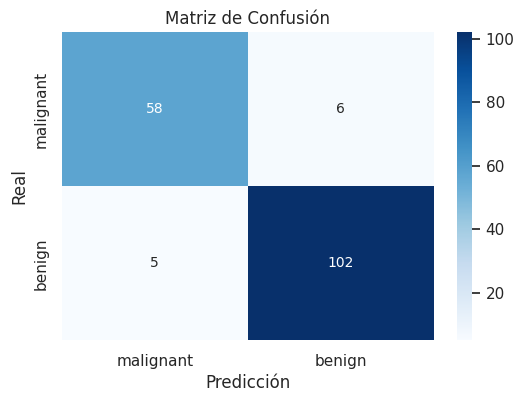

In [10]:
# Crear, entrenar el Random Forest y obtener conjuntos de datos
if df_cancer is not None:
    rf_clf, X_entrenamiento_cancer, X_prueba_cancer, y_entrenamiento_cancer, y_prueba_cancer = \
        crear_entrenar_ensemble_rf(df_cancer, cancer_feature_names, n_estimators_val=100)
else:
    print("El DataFrame df_cancer no está definido. No se puede entrenar el Random Forest.")
    rf_clf = None

### 3.3. Visualización de la Importancia de Características

**Objetivo:**
Mostrar cuáles características son consideradas más importantes por el modelo Random Forest para realizar la clasificación.


Visualizando las 15 características más importantes...


/tmp/ipykernel_53929/1843933964.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


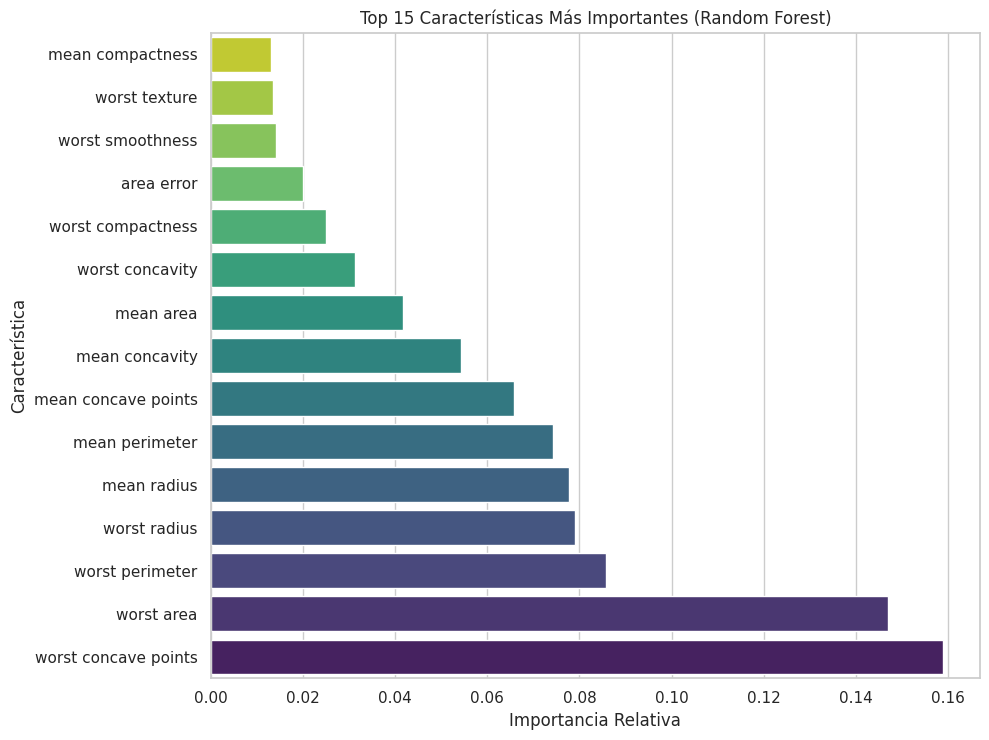

In [11]:
# Visualizar la importancia de las características
if rf_clf is not None:
    visualizar_importancia_caracteristicas(rf_clf, cancer_feature_names, top_n=15)
else:
    print("El clasificador Random Forest no está entrenado. No se puede mostrar la importancia de características.")

### 3.4. Visualización de un Árbol Individual del Ensamble

**Objetivo:**
Inspeccionar la estructura de uno de los árboles de decisión que componen el Random Forest para entender cómo contribuye individualmente.


Visualizando el árbol individual #0 del Random Forest (max_depth=3)...


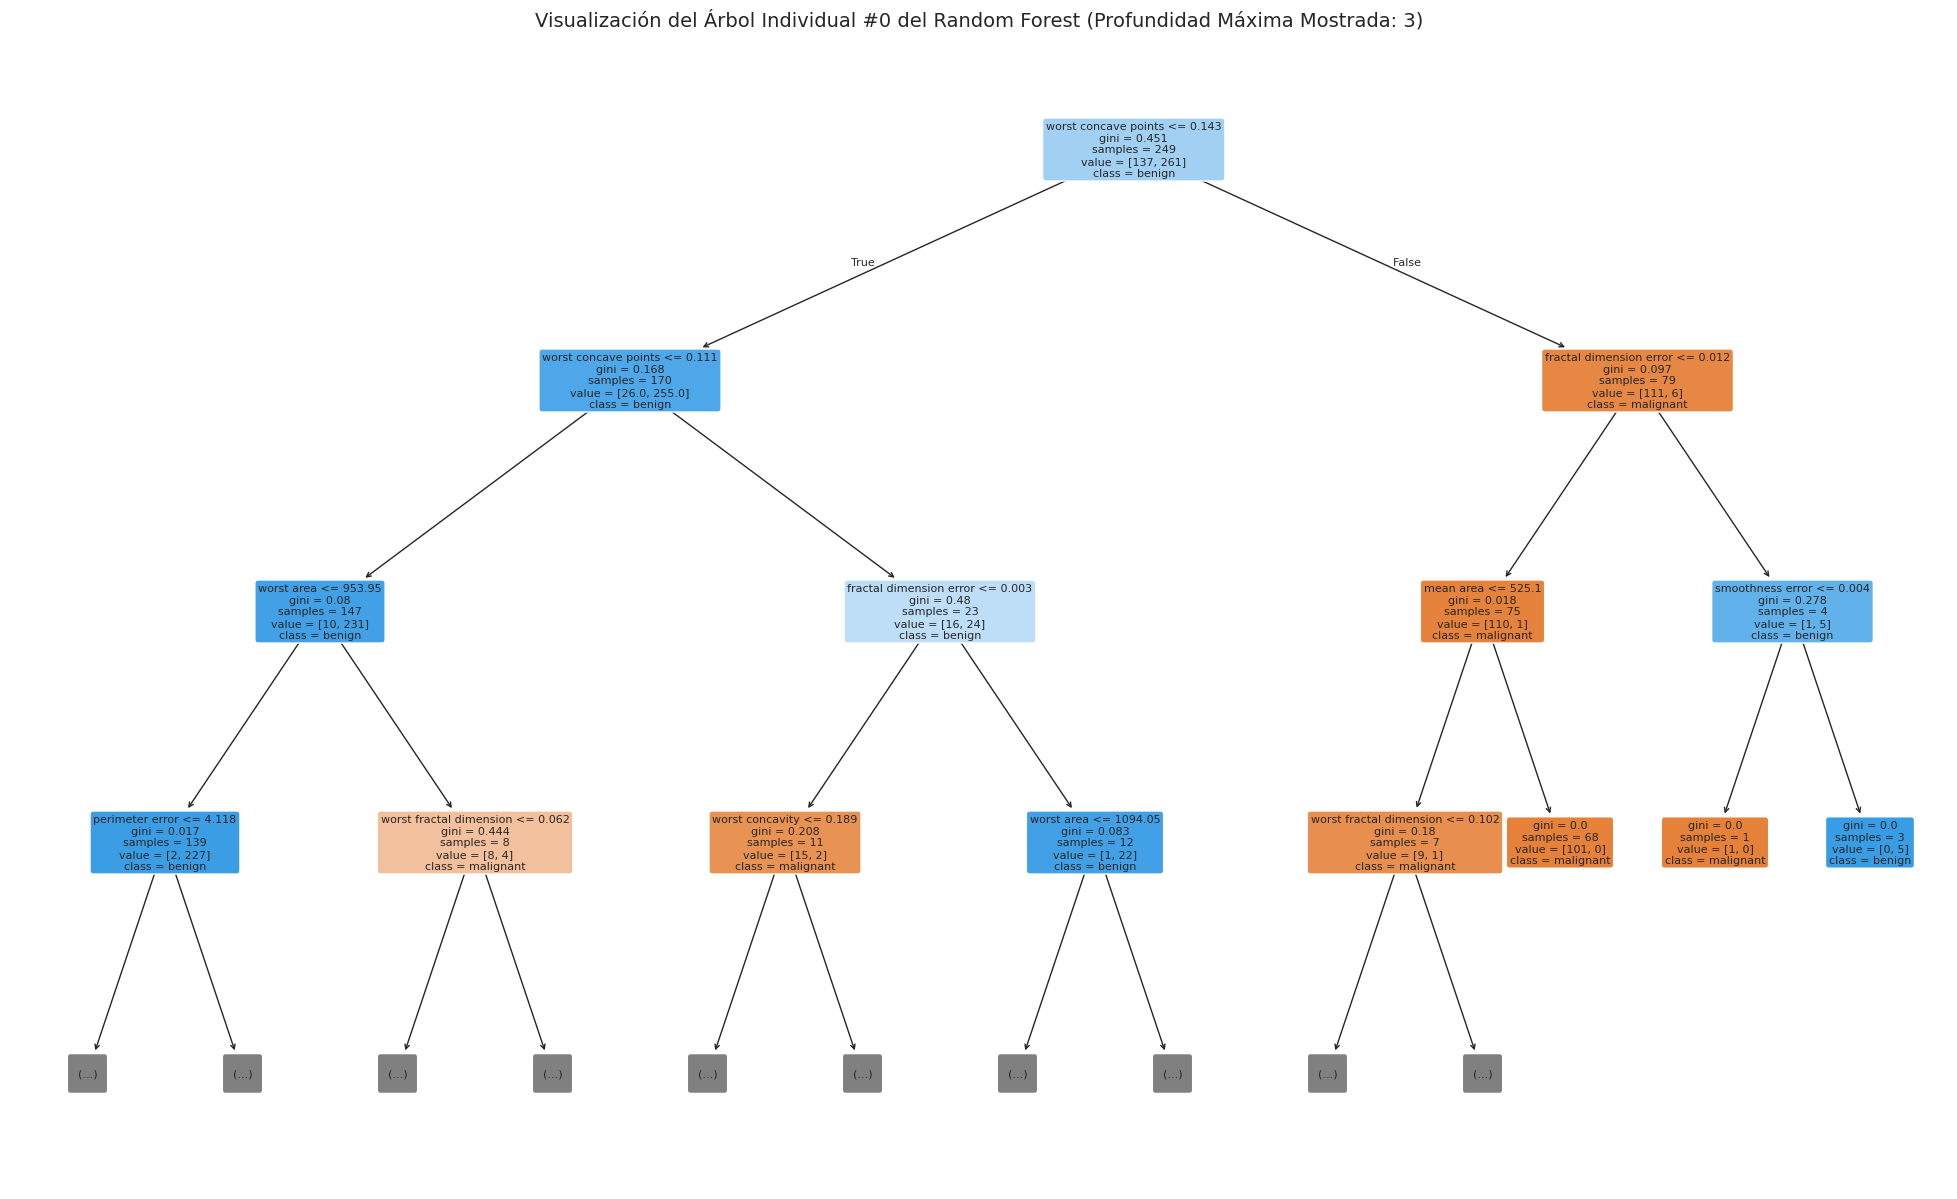

In [12]:
# Visualizar un árbol individual del ensamble
if rf_clf is not None:
    # Visualizar el primer árbol (índice 0) con una profundidad máxima de 3 para legibilidad
    visualizar_un_arbol_del_ensemble(rf_clf, tree_index=0, 
                                     feature_names=cancer_feature_names, 
                                     class_names_list=cancer_target_names, 
                                     max_depth_to_plot=3)
else:
    print("El clasificador Random Forest no está entrenado. No se puede visualizar un árbol individual.")

### 3.5. Análisis de un Ejemplo Específico

**Objetivo:**
Utilizar el Random Forest entrenado para clasificar una muestra con características específicas y observar las probabilidades de predicción.

**Nota:** Los valores del ejemplo deben corresponder a las características del dataset. Aquí se tomará la primera muestra del conjunto de prueba para el análisis.

In [13]:
# Analizar un ejemplo específico usando el Random Forest entrenado
if rf_clf is not None and not X_prueba_cancer.empty:
    # Tomar la primera muestra del conjunto de prueba como ejemplo
    ejemplo_idx = 0
    ejemplo_paciente_features = X_prueba_cancer.iloc[[ejemplo_idx]] # Mantener como DataFrame
    ejemplo_paciente_dict = ejemplo_paciente_features.to_dict(orient='records')[0]
    clase_real_paciente_idx = y_prueba_cancer.iloc[ejemplo_idx]

    print(f"\n--- Ejemplo de Paciente (Muestra #{ejemplo_idx} del conjunto de prueba) ---")
    analizar_ejemplo_especifico_rf(
        rf_clf,
        ejemplo_paciente_dict,
        cancer_feature_names, # Lista completa de nombres de características en orden original
        cancer_target_names,
        clase_real_ejemplo_idx=clase_real_paciente_idx
    )
    
    # Si se quisiera probar con valores inventados, asegurarse que el diccionario 'ejemplo_inventado'
    # tenga todas las claves correspondientes a 'cancer_feature_names'.
    # Ejemplo (valores ficticios, solo para demostración, pueden no ser realistas):
    # ejemplo_inventado = {feat: np.mean(X_entrenamiento_cancer[feat]) for feat in cancer_feature_names}
    # ejemplo_inventado['mean radius'] = 15.0 # Modificar algunos valores clave
    # ejemplo_inventado['mean texture'] = 20.0
    # ejemplo_inventado['worst concave points'] = 0.2
    # print("\n--- Ejemplo Inventado ---")
    # analizar_ejemplo_especifico_rf(rf_clf, ejemplo_inventado, cancer_feature_names, cancer_target_names)

else:
    print("El clasificador Random Forest no está entrenado o el conjunto de prueba está vacío. No se puede analizar el ejemplo.")


--- Ejemplo de Paciente (Muestra #0 del conjunto de prueba) ---

Analizando un ejemplo específico con Random Forest...

Características de la muestra:
- mean radius: 13.73
- mean texture: 22.61
- mean perimeter: 93.6
- mean area: 578.3
- mean smoothness: 0.1131
- mean compactness: 0.2293
- mean concavity: 0.2128
- mean concave points: 0.08025
- mean symmetry: 0.2069
- mean fractal dimension: 0.07682
- radius error: 0.2121
- texture error: 1.169
- perimeter error: 2.061
- area error: 19.21
- smoothness error: 0.006429
- compactness error: 0.05936
- concavity error: 0.05501
- concave points error: 0.01628
- symmetry error: 0.01961
- fractal dimension error: 0.008093
- worst radius: 15.03
- worst texture: 32.01
- worst perimeter: 108.8
- worst area: 697.7
- worst smoothness: 0.1651
- worst compactness: 0.7725
- worst concavity: 0.6943
- worst concave points: 0.2208
- worst symmetry: 0.3596
- worst fractal dimension: 0.1431

Diagnóstico Real: malignant (Clase 0)
Diagnóstico Predicho por R

## 4. Conclusiones del Ejercicio

**Resumen de Hallazgos:**
* Se cargó y exploró el dataset "Breast Cancer Wisconsin", identificando 30 características numéricas para predecir un diagnóstico binario (maligno/benigno).
* Se entrenó un modelo `RandomForestClassifier` con **[Número de estimadores, ej: 100]** árboles.
* El modelo alcanzó una precisión de **[Completar con la precisión obtenida, ej: 0.965]** y un OOB score de **[Completar con OOB score]** en el conjunto de prueba. El reporte de clasificación y la matriz de confusión mostraron **[Describir brevemente el rendimiento por clase, ej: alta sensibilidad para maligno, pocos falsos negativos]**.
* La visualización de la importancia de características reveló que **[Mencionar algunas características importantes, ej: 'worst concave points', 'mean concave points', 'worst radius']** son las más influyentes para la predicción del modelo.
* Se visualizó un árbol individual del ensamble, mostrando la complejidad (o simplicidad, si `max_depth` es bajo) de los componentes del Random Forest.
* El análisis de un ejemplo específico del conjunto de prueba fue **[clasificado correctamente/incorrectamente]** con probabilidades detalladas.

**Fortalezas del Modelo Random Forest:**
* **Alto Rendimiento:** Generalmente proporcionan alta precisión y son robustos al sobreajuste en comparación con un solo árbol de decisión, gracias al promediado de múltiples árboles descorrelacionados.
* **Manejo de Datos de Alta Dimensión:** Funcionan bien con muchas características.
* **Importancia de Características:** Proporcionan una medida útil de la relevancia de las características.
* **No Requiere Escalado de Características:** Al igual que los árboles individuales, son insensibles al escalado monotónico de las características.
* **OOB Score:** Ofrece una estimación del error de generalización sin necesidad de un conjunto de validación separado explícitamente durante el entrenamiento.

**Consideraciones y Mejoras Potenciales:**
* **Ajuste de Hiperparámetros:** Aunque Random Forest funciona bien con los hiperparámetros por defecto, se podría realizar una búsqueda de hiperparámetros (e.g., `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`) usando técnicas como `GridSearchCV` o `RandomizedSearchCV` para optimizar aún más el rendimiento.
* **Interpretabilidad:** Aunque se puede ver la importancia de características y árboles individuales, un ensamble es inherentemente menos interpretable que un solo árbol de decisión.
* **Tiempo de Entrenamiento y Predicción:** Pueden ser más lentos de entrenar y predecir que modelos más simples, especialmente con un gran número de árboles y datos.

**Aprendizaje General:**
Este ejercicio demostró la aplicación de un ensamble Random Forest a un problema de clasificación biomédica. Se ilustró el flujo de trabajo desde la carga de datos hasta la evaluación del modelo y la interpretación de sus resultados, destacando las ventajas de los métodos de ensamble para mejorar la robustez y el rendimiento predictivo. La capacidad de identificar características importantes también es valiosa en muchos dominios.

*(Nota: Los resultados específicos como la precisión, OOB score y las características más importantes deben actualizarse después de ejecutar completamente el notebook.)*